In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import pandas as pd
import os
import tensorflow.keras.losses
import math
import datetime

In [3]:
#Loads in the proper model
model_name='100erun6_19'
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model=models.load_model(os.path.join('Models',model_name),compile=False)
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])

KeyboardInterrupt: 

In [ ]:
#Method for separting label array into useful data points
def split_label(labels):
    center_atom=np.array([labels[0],labels[1]])*32
    neighborvec1=np.array([-labels[2],-labels[3]])*32
    neighborvec2=np.array([-labels[4],-labels[5]])*32
    neighborvec3=np.array([-labels[6],-labels[7]])*32
    neighbors=[]
    neighbors.append(center_atom+neighborvec1)
    neighbors.append(center_atom+neighborvec2)
    neighbors.append(center_atom+neighborvec3)
    return center_atom , neighbors 

#Methods for coloring in the central atom and labels on the images.
def plot_labels():
    plt.plot(center_atom[0],center_atom[1],'o',color='white')
    plt.plot(neighbors[0][0],neighbors[0][1],'o',color='red')
    plt.plot(neighbors[1][0],neighbors[1][1],'o',color='green')
    plt.plot(neighbors[2][0],neighbors[2][1],'o',color='blue')

def plot_test_labels():
    plt.plot(center_atom_t[0],center_atom_t[1],'o',color='xkcd:beige')
    plt.plot(neighbors_t[0][0],neighbors_t[0][1],'o',color='xkcd:dark red')
    plt.plot(neighbors_t[1][0],neighbors_t[1][1],'o',color='xkcd:dark green')
    plt.plot(neighbors_t[2][0],neighbors_t[2][1],'o',color='xkcd:dark blue')


In [34]:
#Loads in real STM images and crops them
def crop_STM(arr,xy,size):
    x,y = xy
    return arr[y:y+size,x:x+size]
image_offset=[150,68]
im=image.load_img("MoC2 _ 349.jpg")
im_arr=image.img_to_array(im).astype('int')
print(im_arr.shape)
im_arr=crop_STM(im_arr,image_offset,25)
print(im_arr.shape)
im_arr=np.array(Image.fromarray(im_arr).resize((32,32)))
im_arr_batch=np.array([im_arr])
plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)

(258, 258, 3)
(25, 25, 3)


TypeError: Cannot handle this data type: (1, 1, 3), <i4

plt.figure()
ax = plt.subplot(1,1,1)
ax.imshow(test_im)

bl7866666666666666_offxneg19333333333333336_offy14666666666666668_as23_strain003533333333333333500360000000000000040002_angleneg18240000000000002.png


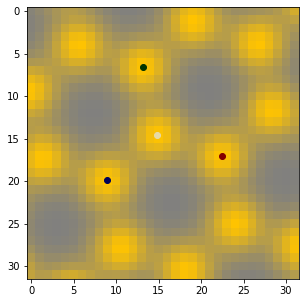

In [27]:
#Loads in a testing image
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Testing_set_6_16'
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))

index=6001
test_im=image.load_img(os.path.join(test_dataset_dir,dft['filename'][index]))
test_im_arr=image.img_to_array(test_im)
test_im_arr_batch=np.array([test_im_arr])
print(dft['filename'][index])
label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
test_labels=dft[label_names].loc[index].to_numpy()

center_atom_t,neighbors_t=split_label(test_labels)

plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(test_im)
plot_test_labels()

In [28]:
#Creates data generators to load images into the model
predict_datagen = ImageDataGenerator(rescale=1./255) 
predict_generator= predict_datagen.flow(
    im_arr_batch,
    batch_size=1
    )
predict_test_datagen=ImageDataGenerator(rescale=1./255)
predict_test_generator=predict_test_datagen.flow(
    test_im_arr_batch,
    batch_size=1
    )

#uses the model to predict center atom and neighbors, assigns locations and vectors accordingly
prediction=model.predict(predict_generator)
prediction=prediction[0]

#assingns relevant datapoints
center_atom,neighbors=split_label(prediction)
#center_atom_t,neighbors_t=split_label(test_labels)

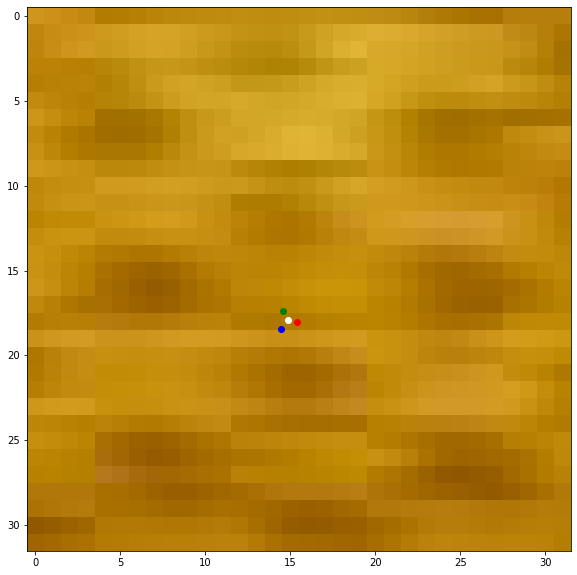

In [29]:
prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))

fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)
plot_labels()
#plot_test_labels()
#plt.savefig(os.path.join(prediction_plots_dir,"train_image_"+str(index)+"_"+model_name))
plt.savefig(os.path.join(prediction_plots_dir,"real_image_test_6_"+model_name))